# Práctica Background Subtraction

En esta segunda práctica del bloque de análisis de secuencias haremos trabajo con 3 técnicas de background subtraction.

En primer lugar debéis implementar vuestro propio método de eliminación de fondo basado en la idea que explicamos del filtro exponencial. Podéis hacer las adaptaciones que encontréis necesario a la idea general del método para mejorar su rendimiento.

En segundo lugar debéis de usar las implementaciones del MOG y del MOG2 que se encuentran en la librería
 [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html).

En tercer lugar lo que quiero es que hagáis una comparativa entre su método y los dos basados en Mixture de gausiano utilizando el dataset de la competición [changedetection.net](http://changedetection.net/) del año 2012.

En concreto debe usar una secuencia de cada categoría exceptuando la de *Thermal*.

Las métricas que a usar para cada secuencia son:

* **TP** : True Positive
* **FP** : False Positive
* **FN** : False Negative
* **TN** : True Negative
* **Re (Recall)** : TP / (TP + FN)
* **F-Measure** : (2 * Precision * Recall) / (Precision + Recall)
* **Precision** : TP / (TP + FP)

Finalmente se pide que hagáis un análisis de los resultados obtenidos por cada secuencia: problemas, carencias, puntos fuertes de los algoritmos ...

**Entrega:**

* Explicación del algoritmo implementado y código fuente.
* Resultados de las secuencias en formato imagen o video.
* Resultados de las secuencias en formato tabla resumen de las métricas.
* Análisis de los resultados

Secuencias a usar:
- baseline: todo
- cameraJitter: badminton, traffic
- dynamicBackground: canoe, fall, fountain02
- intermittentObjectMotion: sofa, 
- shadow: busStation, copyMachine, cubicle, peopleInShade

### Métricas

In [1]:
def recall(tp, fn):
    return (tp/(tp+fn))

def precision(tp, fp):
    return (tp/(tp+fp))

def f_measure(precision, recall):
    return ((2*precision*recall)/(precision+recall))

### Filtro exponencial para _background subtraction_
Parte de la idea de eliminación de fondo más básica: restar el fotograman **_fondo_** (_background_) del fotograma actual para obtener el **_primer plano_** (_foreground_).  
El primer problema o tarea para realizar este algoritmo es conseguir ese fotograma **_fondo_**. Para ello se necesita una imagen que represente el fondo sin ningún otro objeto, pero esto no siempre es posible, por lo tanto hay que buscar otras soluciones. Una de ellas es estimar el fondo como la media o la mediana a partir de los primeros _n_ fotogramas.  
El segundo problema que surge es que el fondo en los casos prácticos varía con el tiempo y por lo tanto es posible que ese fotograma _fondo_ que hemos estimado no nos sirve más tarde. Por lo tanto la mejora que se propone es estimar el fondo recursivamente respecto el fotograma anterior siguiendo la siguiente fórmula: 
$$
\begin{align}
B_t=(1-{\alpha})B_{t-1}+{\alpha}I_t
\end{align}
$$
Donde $B_t$ es la estimación del fondo para el fotograma actual, $B_{t-1}$ es el fondo para el fotograma anterior, $I_t$ es el fotograma actual y $\alpha$ es el factor de aprendizaje que indica cuánto del fotograma actual se considerará fondo para el siguiente fotograma.

In [2]:
from utils import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Para mantener la limpieza del _notebook_ se han definidos las funciones para realizar el análisis dentro del archivo _utils.py_.  
Las funciones que se encuentran son las siguientes:
- **comparator**: compara un _frame_ resultante de un modelo de _background subtraction_ con el resultado esperado (_groundtruth_)
- **loadImages**: devuelve una lista con las imágenes dentro de la carpeta especificada
- **exponentialFilter**: implementación del algoritmo basado en filtro exponencial
- **MOG**: implementación del algoritmo MOG disponible [aquí](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html)
- **MOG2**: implementación del algoritmo MOG2 disponible [aquí](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html)
- **im2vid**: genera video a partir de las imágenes ubicadas en una carpeta
- **showVideo**: muestra el video en una ventana flotante para visualizar mejor el resultado del modelo

Notar que, a pesar de tratarse de algoritmos que trabajan con video, el _dataset_ que se proporciona para realizar las pruebas son imágenes que representan los fotogramas de una secuencia. Por lo tanto, las funciones que se han realizado, se han pensado para trabajar con imágenes en vez de video.

Pasos a seguir para cada secuencia:
1. Cargar las imágenes en una variable (path de las imágenes)
2. Aplicar el filtro deseado EF, MOG y MOG2 (path donde se guardarán las imágenes aplicadas por el filtro)
3. Obtener las métricas con comparator (hacer bucle a lo largo de las imágenes resultado -> path del groundtruth)
4. Mostrar los resultados y videos
5. Comparar los resultados (hacer gráfica a lo largo del

In [4]:
# Path donde se guardarán los resultados de las diferentes secuencias
# highway de baseline
expFilter_highway_path = 'DATA/baseline/results/highway/expFilter/'
MOG_highway_path = 'DATA/baseline/results/highway/MOG/'
MOG2_highway_path = 'DATA/baseline/results/highway/MOG2/'

# camaraJitter badminton dataset output paths
expFilter_badminton_path = 'DATA/cameraJitter/results/badminton/expFilter/'
MOG_badminton_path = 'DATA/cameraJitter/results/badminton/MOG/'
MOG2_badminton_path = 'DATA/cameraJitter/results/badminton/MOG2'

# dynamicBackground canoe dataset output paths
expFilter_canoe_path = 'DATA/dynamicBackground/results/canoe/expFilter/'
MOG_canoe_path = 'DATA/dynamicBackground/results/canoe/MOG/'
MOG2_canoe_path = 'DATA/dynamicBackground/results/canoe/MOG2'

# intermittentObject sofa dataset output paths
expFilter_sofa_path = 'DATA/intermittentObjectMotion/results/sofa/expFilter/' 
MOG_sofa_path = 'DATA/intermittentObjectMotion/results/sofa/MOG'
MOG2_sofa_path = 'DATA/intermittentObjectMotion/results/sofa/MOG2'

# shadow copyMachine dataset output paths
expFilter_copyMachine_path = 'DATA/shadow/results/copyMachine/expFilter/'
MOG_copyMachine_path = 'DATA/shadow/results/copyMachine/MOG'
MOG2_copyMachine_path = 'DATA/shadow/results/copyMachine/MOG2'

# 1. Secuencia _highway_ del dataset _baseline_

Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [5]:
# baseline highway dataset input paths
gt_highway_path = 'DATA/baseline/baseline/highway/groundtruth/*.png'
in_highway_path = 'DATA/baseline/baseline/highway/input/*.jpg'

groundTruth = loadImages(gt_highway_path)
frames = loadImages(in_highway_path)

Loading images: 100%|████████████████████████████████████████████████████████████| 1700/1700 [00:01<00:00, 1199.58it/s]


## 1.1. Algoritmo filtro exponencial

Aplicamos el algoritmo basado en el filtro exponencial que hemos implementado.

In [6]:
# baseline highway dataset output path
expFilter_highway_path = 'DATA/baseline/results/highway/expFilter/'

exponentialFilter(frames, 0.3, expFilter_highway_path, 20, bgFilter ='MEDIAN')

Algorithm application: 100%|██████████████████████████████████████████████████████| 1680/1680 [00:02<00:00, 683.27it/s]


Convertimos la secuencia de imágenes en video para poder visualizar mejor el resultado.

In [7]:
im2vid(expFilter_highway_path+'*.jpg','testvid.mp4')

Converting to video: 100%|███████████████████████████████████████████████████████| 1700/1700 [00:00<00:00, 1716.51it/s]


Mostramos el video en una ventana flotante.

In [9]:
showVideo('testvid.mp4')

### Cálculo de métricas
Calculamos las métricas comparando con el _ground truth_ propocionado. Para cada secuencia se proporciona una ROI (Region Of Interest) sobre la cual se realiza el groundtruth, para simplificar el cálculo se han seleccionada aquellas secuencias en las que la ROI sea toda la imagen. Por otro lado, también se especifica el _frame_ de inicio y final sobre los que se ha de realizar la verificación del algoritmo, por lo tanto solo se calcularán las métricas dentro de ese rango.  

In [12]:
# Cargamos el resultado del filtro exponencial en un array
result_expFilter = loadImages(expFilter_highway_path+'*.jpg')

# ground truth empieza en 470, los frames están numerados de 1 hasta 1700, pero el array de frames va de 0 a 1699
start_frame = 469
end_frame = 1699
total_frames = end_frame-start_frame

# Inicializamos un array para cada métrica donde se el resultado para cada frame
tp_expFilter =  np.zeros(total_frames)
fp_expFilter =  np.zeros(total_frames)
fn_expFilter =  np.zeros(total_frames)
tn_expFilter =  np.zeros(total_frames)

# Calculamos las métricas True Positive, False Positive, False Negative, True Negative para cada frame
for i in range(total_frames):
    tp_expFilter[i], fp_expFilter[i], fn_expFilter[i], tn_expFilter[i] = comparator(result_expFilter[i+start_frame],
                                                                                 groundTruth[i+start_frame])
    
# Calculamos las métricas Recall, Precision y F-measure para cada frame    
recall_expFilter = recall(tp=tp_expFilter, fn=fn_expFilter)
precision_expFilter = precision(tp=tp_expFilter, fp=fp_expFilter)
fMeasure_expFilter = f_measure(precision=precision_expFilter, recall=recall_expFilter)

# Calculamos las métricas anteriores para toda la secuencia en conjunto
tp_expFilter_secuencia = tp_expFilter.sum()
fp_expFilter_secuencia = fp_expFilter.sum()
fn_expFilter_secuencia = fn_expFilter.sum()
tn_expFilter_secuencia = tn_expFilter.sum()

recall_expFilter_secuencia = recall(tp=tp_expFilter_secuencia, fn=fn_expFilter_secuencia)
precision_expFilter_secuencia = precision(tp=tp_expFilter_secuencia, fp=tp_expFilter_secuencia)
fMeasure_expFilter_secuencia = f_measure(precision=precision_expFilter_secuencia, recall=recall_expFilter_secuencia)

Loading images: 100%|████████████████████████████████████████████████████████████| 1700/1700 [00:01<00:00, 1331.68it/s]


In [13]:
precision_expFilter

array([0.05653631, 0.04029126, 0.01318373, ..., 0.62876909, 0.61493709,
       0.6044432 ])

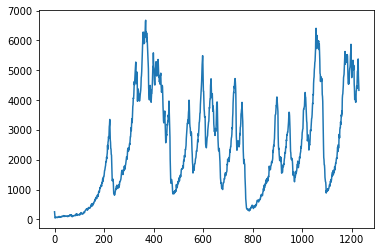

In [17]:
plt.plot(tp_expFilter)

plt.show()

## 1.2. Algoritmo MOG

Aplicamos el algoritmo MOG (Mixture Of Gaussians)

In [18]:
# baseline highway dataset output path
MOG_highway_path = 'DATA/baseline/results/highway/MOG/'

MOG(frames,MOG_highway_path)

Algorithm application: 100%|██████████████████████████████████████████████████████| 1700/1700 [00:04<00:00, 394.87it/s]


In [ ]:
im2vid(MOG_highway_path+'*.jpg','testvid.mp4')

In [ ]:
showVideo('testvid.mp4')

### Cálculo de métricas

In [19]:
# Cargamos el resultado del filtro exponencial en un array
result_MOG = loadImages(MOG_highway_path+'*.jpg')

# ground truth empieza en 470, los frames están numerados de 1 hasta 1700, pero el array de frames va de 0 a 1699
start_frame = 469
end_frame = 1699
total_frames = end_frame-start_frame

# Inicializamos un array para cada métrica donde se el resultado para cada frame
tp_MOG =  np.zeros(total_frames)
fp_MOG =  np.zeros(total_frames)
fn_MOG =  np.zeros(total_frames)
tn_MOG =  np.zeros(total_frames)

# Calculamos las métricas True Positive, False Positive, False Negative, True Negative para cada frame
for i in range(total_frames):
    tp_MOG[i], fp_MOG[i], fn_MOG[i], tn_MOG[i] = comparator(result_MOG[i+start_frame],
                                                            groundTruth[i+start_frame])
    
# Calculamos las métricas Recall, Precision y F-measure para cada frame    
recall_MOG = recall(tp=tp_MOG, fn=fn_MOG)
precision_MOG = precision(tp=tp_MOG, fp=fp_MOG)
fMeasure_MOG = f_measure(precision=precision_MOG, recall=recall_MOG)

# Calculamos las métricas anteriores para toda la secuencia en conjunto
tp_MOG_secuencia = tp_MOG.sum()
fp_MOG_secuencia = fp_MOG.sum()
fn_MOG_secuencia = fn_MOG.sum()
tn_MOG_secuencia = tn_MOG.sum()

recall_MOG_secuencia = recall(tp=tp_MOG_secuencia, fn=fn_MOG_secuencia)
precision_MOG_secuencia = precision(tp=tp_MOG_secuencia, fp=tp_MOG_secuencia)
fMeasure_MOG_secuencia = f_measure(precision=precision_MOG_secuencia, recall=recall_MOG_secuencia)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1700/1700 [00:07<00:00, 232.64it/s]


## 1.3. Algoritmo MOG2

In [24]:
# baseline highway dataset output path
MOG2_highway_path = 'DATA/baseline/results/highway/MOG2/'

MOG2(frames,MOG2_highway_path)

Algorithm application: 100%|██████████████████████████████████████████████████████| 1700/1700 [00:04<00:00, 344.89it/s]


In [ ]:
# Cargamos el resultado del filtro exponencial en un array
result_MOG2 = loadImages(MOG2_highway_path+'*.jpg')

# ground truth empieza en 470, los frames están numerados de 1 hasta 1700, pero el array de frames va de 0 a 1699
start_frame = 469
end_frame = 1699
total_frames = end_frame-start_frame

# Inicializamos un array para cada métrica donde se el resultado para cada frame
tp_MOG2 =  np.zeros(total_frames)
fp_MOG2 =  np.zeros(total_frames)
fn_MOG2 =  np.zeros(total_frames)
tn_MOG2 =  np.zeros(total_frames)

# Calculamos las métricas True Positive, False Positive, False Negative, True Negative para cada frame
for i in range(total_frames):
    tp_MOG2[i], fp_MOG2[i], fn_MOG2[i], tn_MOG2[i] = comparator(result_MOG2[i+start_frame],
                                                            groundTruth[i+start_frame])
    
# Calculamos las métricas Recall, Precision y F-measure para cada frame    
recall_MOG2 = recall(tp=tp_MOG2, fn=fn_MOG2)
precision_MOG2 = precision(tp=tp_MOG2, fp=fp_MOG2)
fMeasure_MOG2 = f_measure(precision=precision_MOG2, recall=recall_MOG2)

# Calculamos las métricas anteriores para toda la secuencia en conjunto
tp_MOG2_secuencia = tp_MOG2.sum()
fp_MOG2_secuencia = fp_MOG2.sum()
fn_MOG2_secuencia = fn_MOG2.sum()
tn_MOG2_secuencia = tn_MOG2.sum()

recall_MOG2_secuencia = recall(tp=tp_MOG2_secuencia, fn=fn_MOG2_secuencia)
precision_MOG2_secuencia = precision(tp=tp_MOG2_secuencia, fp=tp_MOG2_secuencia)
fMeasure_MOG2_secuencia = f_measure(precision=precision_MOG2_secuencia, recall=recall_MOG2_secuencia)

## Comparación resultados

# 2. Secuencia _badminton_ del dataset _cameraJitter_

Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [26]:
#camaraJitter  badminton dataset input
gt_badminton_path = 'DATA/cameraJitter/cameraJitter/badminton/groundtruth/*.png'
in_badminton_path = 'DATA/cameraJitter/cameraJitter/badminton/input/*.jpg'

groundTruth = loadImages(gt_badminton_path)
frames = loadImages(in_badminton_path)

Loading images: 100%|█████████████████████████████████████████████████████████████| 1150/1150 [00:08<00:00, 129.45it/s]


## 2.1. Algoritmo filtro exponencial

In [ ]:
# camaraJitter badminton dataset output path
expFilter_badminton_path = 'DATA/cameraJitter/results/badminton/expFilter/'


### Cálculo de métricas

## 2.2. Algoritmo MOG

In [ ]:
# camaraJitter badminton dataset output paths
MOG_badminton_path = 'DATA/cameraJitter/results/badminton/MOG/'

### Cálculo de métricas

## 2.3. Algoritmo MOG

In [ ]:
# camaraJitter badminton dataset output paths
MOG2_badminton_path = 'DATA/cameraJitter/results/badminton/MOG2'

### Cálculo de métricas

## Comparación resultados

# 3. Secuencia _canoe_ del dataset _dynamicBackground_

In [ ]:
Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [ ]:
# dynamicBackground  canoe dataset input
gt_canoe_path = 'DATA/dynamicBackground/dynamicBackground/canoe/groundtruth/*.png'
in_canoe_path = 'DATA/dynamicBackground/dynamicBackground/canoe/input/*.jpg'

groundTruth = loadImages(gt_canoe_path)
frames = loadImages(in_canoe_path)

# 4. Secuencia _sofa_ del dataset _intermittentObjectMotion_

In [ ]:
Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [ ]:
# intermittentObjectMotion sofa dataset input
gt_sofa_path = 'DATA/intermittentObjectMotion/intermittentObjectMotion/sofa/groundtruth/*.png'
in_sofa_path = 'DATA/intermittentObjectMotion/intermittentObjectMotion/sofa/input/*.jpg'

groundTruth = loadImages(gt_sofa_path)
frames = loadImages(in_sofa_path)

# 5. Secuencia _copyMachine_ del dataset _shadow_

In [ ]:
Cargamos las imágenes de entrada y el ground truth con el que se calcularán las métricas.

In [ ]:
# shadow copyMachine dataset input
gt_copyMachine_path = 'DATA/shadow/shadow/copyMachine/groundtruth/*.png'
in_copyMachine_path = 'DATA/shadow/shadow/copyMachine/input/*.jpg'

groundTruth = loadImages(gt_copyMachine_path)
frames = loadImages(in_copyMachine_path)